In [ ]:
!git clone --recursive https://github.com/bemc22/GeneralizedR2R
%cd GeneralizedR2R
!pip install ./deepinv/

In [ ]:
r"""
Self-supervised learning with Generalized Recorrupted-to-Recovered (GR2R)
====================================================================================================

This example shows you how to train a reconstruction network for an denoising problem on a fully self-supervised way, i.e., using corrupted measurement data only.
"""

import os
import deepinv as dinv
from torch.utils.data import DataLoader
import torchvision
import torch
from pathlib import Path
from torchvision import transforms
from deepinv.optim.prior import PnP
from deepinv.utils.demo import load_dataset, load_degradation
import wandb
import argparse
from torch.utils.data import DataLoader, random_split
from deepinv.loss import PSNR, SSIM, Loss, SupLoss

from deepinv.training import train

/home/bemc/miniconda3/envs/deepinv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.1.1 available.


In [ ]:
class Args:
    batch_size  = 50
    loss        = "gr2r_mse"
    epochs      = 800
    lr          = 1e-4
    noise       = None
    trial       = 0
    alpha       = 0.2

args = Args()

In [ ]:
noise_distribution = 'gaussian' # @param ["gaussian", "poisson", "gamma"]

if noise_distribution == "gaussian":
    args.noise     = 0.1
    noise_model    = dinv.physics.GaussianNoise(args.noise)

elif noise_distribution == "poisson":
    args.noise     = 0.1
    noise_model    = dinv.physics.PoissonNoise(args.noise)
    noise_model.sigma = args.noise

elif noise_distribution == "gamma":
    args.noise     = 5.0
    noise_model    = dinv.physics.GammaNoise(args.noise)
    noise_model.sigma = args.noise

r2r_loss = dinv.loss.R2RLoss(noise_model=noise_model, alpha=args.alpha)
# print actual setup
print("Selecting noise model: ", noise_distribution)
print("Noise level: ", args.noise)
print("Alpha: ", args.alpha)

Selecting noise model:  gaussian
Noise level:  0.1
Alpha:  0.2


In [ ]:
# ---------------------------------------------------------------
# Setup paths for data loading and results.
# ---------------------------------------------------------------

BASE_DIR = Path(".")
# PROJECT_NAME = "denoising-poisson"
PROJECT_NAME = f"denoising-{noise_distribution}"
ORIGINAL_DATA_DIR =  Path("./data")
DATA_DIR = ORIGINAL_DATA_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts" / PROJECT_NAME
verbose   = True
wandb_vis = False

# Set the global random seed from pytorch to ensure reproducibility of the example.
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 23148 MiB free memory 


In [ ]:
# print  all the arguments
trial_id = args.trial
torch.manual_seed(trial_id)

run_name = f"{args.loss}-{args.noise}"

wandb_setup = {
    "project": PROJECT_NAME,
    "config": args,
    "name": run_name,
}

In [ ]:
# # ----------------------------------------------------------------------------------
# Generate a dataset of knee images and load it.
# ----------------------------------------------------------------------------------
from deepinv.datasets import SimpleFastMRISliceDataset
from deepinv.utils.demo import get_data_home

# defined physics
physics = dinv.physics.Denoising(noise_model=noise_model)

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers     = 0 if torch.cuda.is_available() else 0
n_images_max    = 900 # if is greater that train set, image may will duplicated

my_dataset_name = "mri_gaussian_denoising"
operation = f"Denoising_{args.noise}"
train_dataset_name = f"fastmri_knee_singlecoil"
measurement_dir = DATA_DIR / train_dataset_name / operation

# check if the dataset is already generated
# if not, generate it


img_size = 256
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomCrop((img_size, img_size))
#     ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.CenterCrop((img_size, img_size))
# ])
transform = transforms.Compose([transforms.Resize(img_size)])

# div2k_train_path    = ORIGINAL_DATA_DIR / "DIV2K_train_HR.zip"
# div2k_test_path     = ORIGINAL_DATA_DIR / "DIV2K_valid_HR.zip"

download_train  = True # !os.path.exists(div2k_train_path)
download_test   = True # !os.path.exists(div2k_test_path)

# train_dataset    =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="train", transform=transform, download=download_train)
# test_dataset     =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="val", transform=test_transform, download=download_test)

train_dataset = SimpleFastMRISliceDataset(
    get_data_home(), transform=transform, train_percent=0.5, train=True, download=True
)

test_dataset = SimpleFastMRISliceDataset(
    get_data_home(), transform=transform, train_percent=0.5, train=False
)


if not os.path.exists(measurement_dir / f"{my_dataset_name}0.h5"):
    deepinv_datasets_path = dinv.datasets.generate_dataset(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        physics=physics,
        device=device,
        save_dir=measurement_dir,
        train_datapoints=n_images_max,
        num_workers=num_workers,
        dataset_filename=str(my_dataset_name),
    )
else:
    deepinv_datasets_path = measurement_dir / f"{my_dataset_name}0.h5"

train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

In [ ]:
# Set up the reconstruction network
# ---------------------------------------------------------------

n_channels = 2

# model = dinv.models.ArtifactRemoval( dinv.models.DRUNet( in_channels=n_channels,
#                             out_channels=n_channels,
#                             pretrained=None,
#                             nc=[16, 32, 64, 128]
#                             ).to(device)
# )

model = dinv.models.ArtifactRemoval( dinv.models.DnCNN(
                                in_channels=n_channels,
                                 out_channels=n_channels,
                                 pretrained=None,
                                 depth=7,
                                 ).to(device)
)

# print number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


# Set up the training parameters
# --------------------------------------------

epochs        = args.epochs
learning_rate = args.lr
batch_size    = args.batch_size # if torch.cuda.is_available() else 1
noise_level   = args.noise


if args.loss == "sup":   # SUPERVISED LOSS
    loss = dinv.loss.SupLoss()

elif args.loss == "gr2r_mse": # GENERALIZED R2R LOSS - MSE VARIANT
    loss     = [ r2r_loss ]
    # model    = r2r_loss.adapt_model(model)

elif args.loss == "neigh": # NEIGHBORHOOD LOSS

    neigh_loss = dinv.loss.Neighbor2Neighbor()
    loss = [ neigh_loss ]


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs * 0.8) + 1)


Number of parameters: 187010


The model has 187010 trainable parameters


/home/bemc/miniconda3/envs/deepinv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Train epoch 0: TotalLoss=0.063, PSNR=18.995, SSIM=0.105
Eval epoch 0: PSNR=21.383, SSIM=0.149
Train epoch 1: TotalLoss=0.058, PSNR=21.263, SSIM=0.147
Eval epoch 1: PSNR=23.358, SSIM=0.199
Train epoch 2: TotalLoss=0.055, PSNR=22.819, SSIM=0.185
Eval epoch 2: PSNR=24.82, SSIM=0.253
Train epoch 3: TotalLoss=0.054, PSNR=23.975, SSIM=0.226
Eval epoch 3: PSNR=25.893, SSIM=0.307
Train epoch 4: TotalLoss=0.053, PSNR=24.84, SSIM=0.264
Eval epoch 4: PSNR=26.684, SSIM=0.354
Train epoch 5: TotalLoss=0.053, PSNR=25.515, SSIM=0.297
Eval epoch 5: PSNR=27.297, SSIM=0.391
Train epoch 6: TotalLoss=0.052, PSNR=26.082, SSIM=0.327
Eval epoch 6: PSNR=27.813, SSIM=0.423
Train epoch 7: TotalLoss=0.052, PSNR=26.585, SSIM=0.354
Eval epoch 7: PSNR=28.265, SSIM=0.453
Train epoch 8: TotalLoss=0.052, PSNR=27.045, SSIM=0.381
Eval epoch 8: PSNR=28.667, SSIM=0.476
Train epoch 9: TotalLoss=0.052, PSNR=27.457, SSIM=0.403
Eval epoch 9: PSNR=29.023, SSIM=0.497
Train epoch 10: TotalLoss=0.052, PSNR=27.836, SSIM=0.427
Eval 

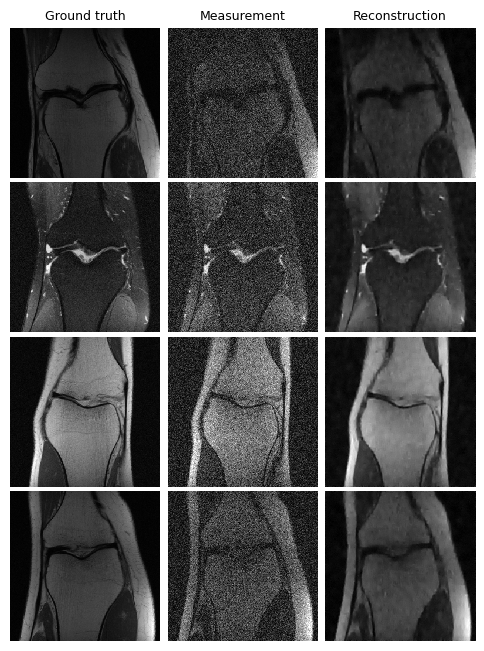

Eval epoch 199: PSNR=34.492, SSIM=0.746


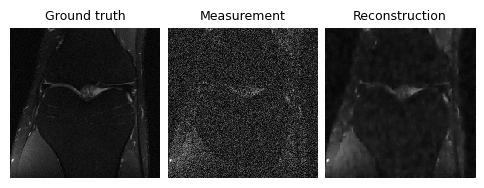

Train epoch 200: TotalLoss=0.05, PSNR=34.036, SSIM=0.829
Eval epoch 200: PSNR=34.666, SSIM=0.867
Train epoch 201: TotalLoss=0.05, PSNR=34.068, SSIM=0.861
Eval epoch 201: PSNR=34.754, SSIM=0.868
Train epoch 202: TotalLoss=0.05, PSNR=34.058, SSIM=0.825
Eval epoch 202: PSNR=34.679, SSIM=0.828
Train epoch 203: TotalLoss=0.05, PSNR=34.065, SSIM=0.844
Eval epoch 203: PSNR=34.735, SSIM=0.869
Train epoch 204: TotalLoss=0.05, PSNR=34.065, SSIM=0.852
Eval epoch 204: PSNR=34.793, SSIM=0.882
Train epoch 205: TotalLoss=0.05, PSNR=34.094, SSIM=0.841
Eval epoch 205: PSNR=34.642, SSIM=0.816
Train epoch 206: TotalLoss=0.05, PSNR=34.05, SSIM=0.819
Eval epoch 206: PSNR=34.769, SSIM=0.877
Train epoch 207: TotalLoss=0.05, PSNR=34.087, SSIM=0.85
Eval epoch 207: PSNR=34.58, SSIM=0.838
Train epoch 208: TotalLoss=0.05, PSNR=34.056, SSIM=0.839
Eval epoch 208: PSNR=34.738, SSIM=0.845
Train epoch 209: TotalLoss=0.05, PSNR=34.101, SSIM=0.845
Eval epoch 209: PSNR=34.496, SSIM=0.81
Train epoch 210: TotalLoss=0.05, P

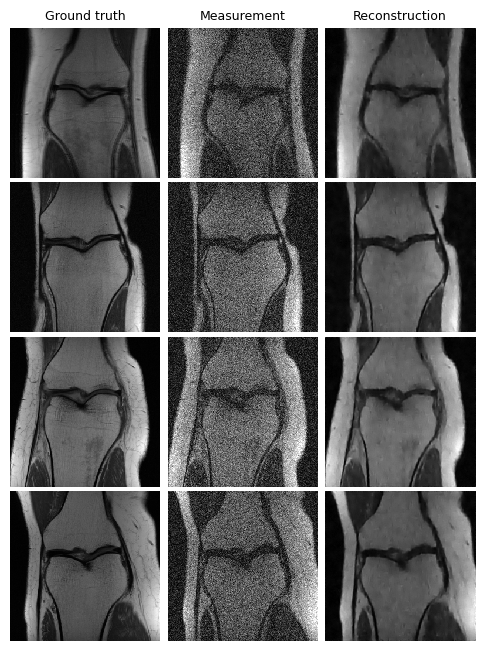

Eval epoch 399: PSNR=35.145, SSIM=0.897


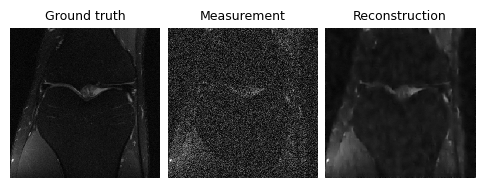

Train epoch 400: TotalLoss=0.05, PSNR=34.484, SSIM=0.847
Eval epoch 400: PSNR=35.049, SSIM=0.844
Train epoch 401: TotalLoss=0.05, PSNR=34.518, SSIM=0.871
Eval epoch 401: PSNR=35.155, SSIM=0.89
Train epoch 402: TotalLoss=0.05, PSNR=34.526, SSIM=0.871
Eval epoch 402: PSNR=35.138, SSIM=0.89
Train epoch 403: TotalLoss=0.05, PSNR=34.538, SSIM=0.879
Eval epoch 403: PSNR=35.155, SSIM=0.896
Train epoch 404: TotalLoss=0.05, PSNR=34.45, SSIM=0.831
Eval epoch 404: PSNR=34.852, SSIM=0.774
Train epoch 405: TotalLoss=0.05, PSNR=34.48, SSIM=0.847
Eval epoch 405: PSNR=35.048, SSIM=0.835
Train epoch 406: TotalLoss=0.05, PSNR=34.527, SSIM=0.87
Eval epoch 406: PSNR=35.117, SSIM=0.867
Train epoch 407: TotalLoss=0.05, PSNR=34.51, SSIM=0.882
Eval epoch 407: PSNR=35.155, SSIM=0.895
Train epoch 408: TotalLoss=0.05, PSNR=34.474, SSIM=0.848
Eval epoch 408: PSNR=35.108, SSIM=0.896
Train epoch 409: TotalLoss=0.05, PSNR=34.533, SSIM=0.879
Eval epoch 409: PSNR=35.133, SSIM=0.876
Train epoch 410: TotalLoss=0.05, PSN

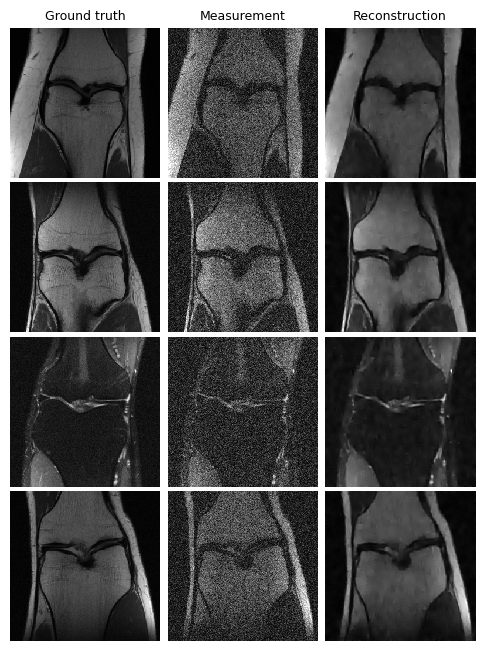

Eval epoch 599: PSNR=35.268, SSIM=0.863


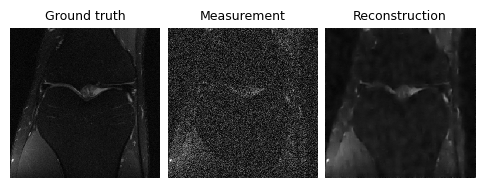

Train epoch 600: TotalLoss=0.05, PSNR=34.712, SSIM=0.855
Eval epoch 600: PSNR=35.223, SSIM=0.83
Train epoch 601: TotalLoss=0.05, PSNR=34.741, SSIM=0.88
Eval epoch 601: PSNR=35.335, SSIM=0.901
Train epoch 602: TotalLoss=0.05, PSNR=34.713, SSIM=0.872
Eval epoch 602: PSNR=35.198, SSIM=0.841
Train epoch 603: TotalLoss=0.05, PSNR=34.732, SSIM=0.878
Eval epoch 603: PSNR=35.347, SSIM=0.898
Train epoch 604: TotalLoss=0.05, PSNR=34.75, SSIM=0.879
Eval epoch 604: PSNR=35.361, SSIM=0.9
Train epoch 605: TotalLoss=0.05, PSNR=34.762, SSIM=0.894
Eval epoch 605: PSNR=35.356, SSIM=0.89
Train epoch 606: TotalLoss=0.05, PSNR=34.734, SSIM=0.874
Eval epoch 606: PSNR=35.297, SSIM=0.901
Train epoch 607: TotalLoss=0.05, PSNR=34.729, SSIM=0.876
Eval epoch 607: PSNR=35.354, SSIM=0.9
Train epoch 608: TotalLoss=0.05, PSNR=34.717, SSIM=0.885
Eval epoch 608: PSNR=35.222, SSIM=0.877
Train epoch 609: TotalLoss=0.05, PSNR=34.742, SSIM=0.881
Eval epoch 609: PSNR=35.357, SSIM=0.896
Train epoch 610: TotalLoss=0.05, PSNR=

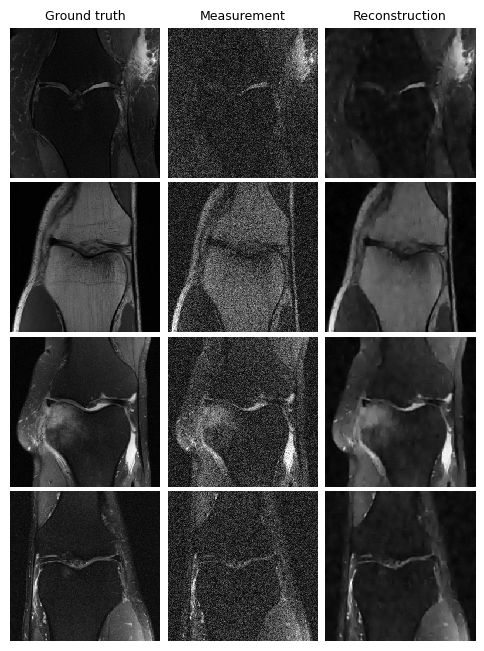

Eval epoch 799: PSNR=35.405, SSIM=0.902


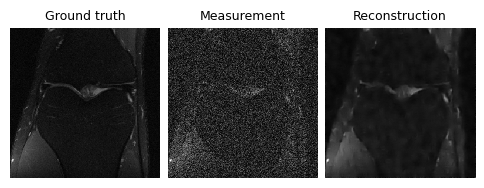

In [ ]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, num_workers=num_workers, shuffle=False
)

trainer = dinv.Trainer(
    metrics=[ PSNR(), SSIM() ],
    model=model,
    physics=physics,
    epochs=epochs,
    scheduler=scheduler,
    losses=loss,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    plot_images=True,
    device=device,
    save_path=Path(CKPT_DIR / f"noise={args.noise}"  / args.loss ),
    verbose=verbose,
    wandb_vis=False,
    show_progress_bar=False,
    ckp_interval=1,
    wandb_setup=None,
    eval_dataloader=test_dataloader,
    freq_plot=200,
)

model = trainer.train()

EVALUATING THE MODEL ON THE TEST DATASET
Eval epoch 0: PSNR=35.358, PSNR no learning=20.005, SSIM=0.902, SSIM no learning=0.126


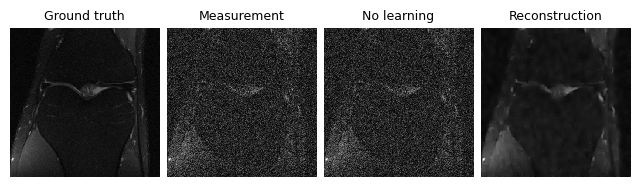

Test results:
PSNR no learning: 20.005 +- 0.020
PSNR: 35.358 +- 1.176
SSIM no learning: 0.126 +- 0.019
SSIM: 0.902 +- 0.027


{'PSNR no learning': 20.004791703942704,
 'PSNR no learning_std': 0.020400981937728928,
 'PSNR': 35.358095926781225,
 'PSNR_std': 1.176101990920144,
 'SSIM no learning': 0.1258647429616484,
 'SSIM no learning_std': 0.019475929126825744,
 'SSIM': 0.9016822723493184,
 'SSIM_std': 0.026844649372037167}

In [ ]:
# Evaluate the model on the test dataset
print("EVALUATING THE MODEL ON THE TEST DATASET")
trainer.freq_plot = 1
trainer.test(test_dataloader)